In [1]:
import pandas as pd 
import numpy as np 
import pyro
import torch
from torch.distributions import constraints
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
import pyro.poutine as poutine
from pyro.infer import TraceEnum_ELBO, SVI, config_enumerate, infer_discrete
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.stats

In [2]:
# Model declaration for GMM Cluster
K=2
def model(data, K=2, d=2):
    # GMM parameters. 
    pi = pyro.sample('pi', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        # TODO : change initializations
        mu = pyro.sample('mu', dist.MultivariateNormal(torch.zeros(d), 1*torch.eye(d)))
        sigma = pyro.sample('sigma', dist.InverseGamma(1,1))

    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(pi))
        sigma_ = sigma[assignment].repeat(d, d, 1).transpose(2, 0)
        sigma_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(mu[assignment], sigma_), obs = data)
guide = AutoDelta(poutine.block(model, expose=['pi','mu','sigma']))

# Running the GMM model with SVI for this iteration.

In [3]:
# note that both covariance matrices are diagonal
num_samples = 1000
mu1 = torch.tensor([0., 5.])
sig1 = torch.tensor([[2., 0.], [0., 3.]])

mu2 = torch.tensor([5., 0.])
sig2 = torch.tensor([[4., 0.], [0., 1.]])

# generate samples
dist1 = dist.MultivariateNormal(mu1, sig1)
samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

dist2 = dist.MultivariateNormal(mu2, sig2)
samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]


In [4]:
dummy_data = torch.cat((torch.stack(samples1), torch.stack(samples2)))


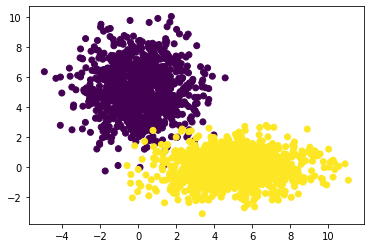

In [5]:
plt.scatter(dummy_data[:,0], dummy_data[:,1], c = [0 for i in range(num_samples)] + [1 for i in range(num_samples)])


# Inference using SVI 

In [6]:
optim = pyro.optim.Adam({'lr':0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)


In [7]:
def initialize(seed = 42):
    pyro.set_rng_seed(seed) 
    pyro.clear_param_store()
    loss = svi.loss(model, guide, dummy_data)
    return loss

loss, seed = min((initialize(seed), seed) for seed in range(1000))
initialize(seed)

28184.865234375

## Adding parameter, losses to monitor.

In [8]:
gradiant_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name:gradiant_norms[name].append(g.norm().item()))
    
losses = []
for i in range(1151):
    loss = svi.step(dummy_data)
    losses.append(loss)

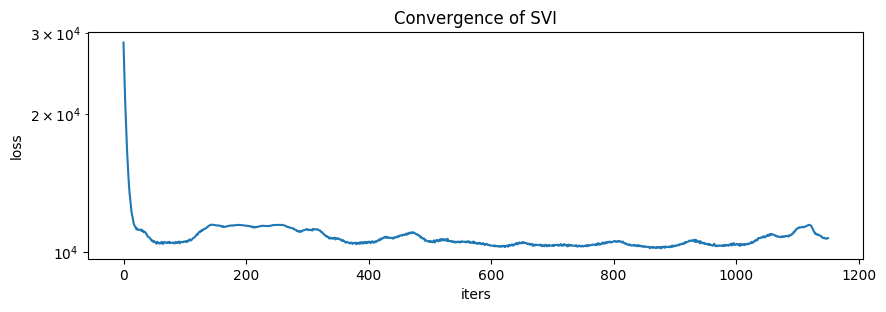

In [9]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');


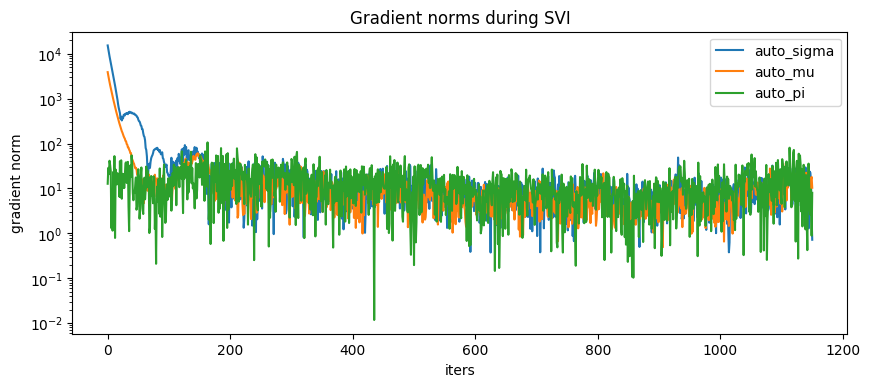

In [10]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradiant_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');


In [11]:
map_estimates = guide(dummy_data)
pi = map_estimates['pi']
mu = map_estimates['mu']
sigma = map_estimates['sigma']
print('pi = {}'.format(pi.data.numpy()))
print('mu = {}'.format(mu.data.numpy()))
print('sigma = {}'.format(sigma.data.numpy()))


pi = [0.09930389 0.9006961 ]
mu = [[2.4959655 2.4471004]
 [2.5059032 2.5608525]]
sigma = [8.768412 8.852697]


# Infering Mixture Assignments

In [12]:
guide_trace = poutine.trace(guide).get_trace(dummy_data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data):
    inferred_model = infer_discrete(trained_model,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

ass = classifier(dummy_data)


In [24]:
colo = ['red' if x==0 else 'blue' for x in ass.tolist()] 

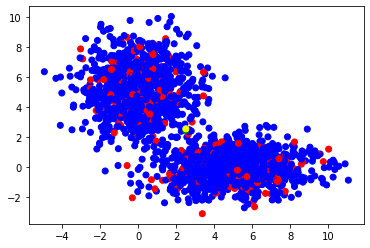

In [26]:
plt.scatter(x = dummy_data[:,0].tolist()+[float(mu[0][0]), float(mu[1][0])],
            y = dummy_data[:,1].tolist()+[float(mu[0][1]), float(mu[1][1])],
            c = colo)